In [1]:
# List of Imports
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import pandana as pdna
from pandana.loaders import osm
from shapely.geometry import Point
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Methods
# Generate a geodataframe with X and Y coordinates
def generate_points(row):
    point = Point(row.x, row.y)
    return point

# Plot the accessibility map to the nearest element
def plot_nearest_amenity(amenity,accessibility, n):
    fig_kwargs = {'figsize': [20, 20]}
    bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
    plot_kwargs = {'cmap': 'YlOrBr_r', 's': 8, 'edgecolor': 'none'}
    bmap,fig, ax = network.plot(accessibility[n], bbox=bbox,
                               fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)
    ax.set_facecolor('k')
    ax.set_title('Pedestrian accessibility (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);



## Load all necessary data and prepare datasets for processing

In [3]:
# Load data Polygons - Gargalo 1
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})

# Add a column with all centroids
polygons = polygons.to_crs({'init': 'epsg:4326'})
# polygons['sCentroid'] = polygons.centroid

# Remove residual data from Polygons
# polygons = polygons[polygons['LUG11DESIG']!='Residual']

In [4]:
# Load Schools Data
# Old Schools ShapeFile with some missing points, and with some Schools with wrong Lat Long
# schoolsNetworkTotal = gpd.read_file('./data/escolas_portugal/Escolas_EB1_2019_2.shp', dtype={'CODCONCELH':str})
schoolsNetworkTotal = gpd.read_file('./data/escolas_portugal_corrigido/gdf_escolas_publicas_1CEB.shp', dtype={'BGRI11':str})

# Select only the schools with primary education
schoolsNetworkTotal = schoolsNetworkTotal[schoolsNetworkTotal['ENSINOS_LI'].str.contains('B')]

# convert coordinates data from schools
schoolsNetworkTotal = schoolsNetworkTotal.to_crs({'init': 'epsg:4326'})
# Change CONCELHO to upper case to match with polygons network dataframe correspondence
schoolsNetworkTotal['CONCELHO'] = schoolsNetworkTotal['CONCELHO'].str.upper()

In [5]:
# Load Portugal Municipalities Polygons - epsg:3763' CAOP 2018
polygons_concelhos = gpd.read_file('./data/freguesias_portugal/OgrGeoJSON.shp')

# Dissolve to get Municipalities over the inumerous polygons
dissolveByPreference='Concelho'
polygons_concelhos = polygons_concelhos.dissolve(by=dissolveByPreference,as_index=False)
polygons_concelhos = polygons_concelhos.to_crs({'init': 'epsg:4326'})

In [6]:
# Load IQ data
iq_bgri = pd.read_excel('./data/qi_portugal.xlsx', dtype={'BGRI11':str})

## Start of accessbility computation and Logic
Variables

In [18]:
# Max Distance used in accessibility calculation - Increases accuracy
maxDistance = 60000
# List of 'CONCELHO's to be used in analysis. Remember to use it as Uppercase, if different then default.

resultDfMerged = pd.DataFrame()

In [19]:
schoolsNetworkTotal.at[1165,'CONCELHO'] = 'MÊDA'

In [52]:
councils = polygons_concelhos.dissolve(by='Concelho',as_index=False).Concelho.tolist()

In [53]:
len(councils) # CHECK IF IT IS CORRECT

278

In [33]:
councils = [councils[0]]

['ABRANTES']

In [44]:
polygons[polygons['DTMN11']=='1401'].shape

(1139, 10)

In [39]:
for council in councils:
    print('Starting accessbility for {}...'.format(council))
    # Load Network saved data
    try:
        store = pd.HDFStore('./data/networks/'+council)
    except:
        print('There is no network for {}'.format(str(council)))
        continue

    nodes = store.nodes
    edges = store.edges

    # Create a geopandas from nodes network
    nodes['geometry'] = nodes.apply(lambda row: generate_points(row), axis=1)
    nodes = gpd.GeoDataFrame(nodes)

    # Identify every node with the respective subsection BGRI11 
    nodes = gpd.sjoin(nodes, polygons[['BGRI11', 'geometry']], how='left', op='intersects') # <== POSSÍVEL ERRO

    # Network precomputation
    network = pdna.Network(nodes.x,
                           nodes.y,
                           edges['from'], 
                           edges['to'],
                           edges[['dist']],
                           twoway=False)
    network.precompute(maxDistance)

    # Get only the schools defined in Council
   
    schoolsNetwork = schoolsNetworkTotal[schoolsNetworkTotal['CONCELHO'] == council]
    
    # Break the X and Y from the schools Networks - Verificar esse código
    schoolX = []
    schoolY = []
    for e in schoolsNetwork.iterrows():
        # 30 is the Magic Number which corresponds to the geometry index in the series
        schoolX.append(e[1][30].x)
        schoolY.append(e[1][30].y)
    schoolsNetwork['schoolX'] = schoolX
    schoolsNetwork['schoolY'] = schoolY

    # Set the pois with the X and Y
    try:
        network.set_pois('school', maxDistance, 3, schoolsNetwork['schoolX'], schoolsNetwork['schoolY'])
    except Exception as ex:
        print("Caught exception {}".format(ex))
        print('There is no school on given database for {}'.format(council))
        continue
    # Create the Accessbility Dataframe
    a = network.nearest_pois(maxDistance, "school", num_pois=3)
    
    # Plot Graph
    bounds = polygons_concelhos[polygons_concelhos['Concelho']==council].total_bounds
    bbox = [bounds[1], bounds[0], bounds[3], bounds[2]]
#     plot_nearest_amenity('school',a,1)
#     plot_nearest_amenity('school',a,3)
#     figN1.savefig('./data/accessibility/'+council+'/figN1.csv')
#     figN3.savefig('./data/accessibility/'+council+'/figN3.csv')
    
    # Merge data From the Nodes DF to get the Points BGRI11 reference
    a = pd.merge(a, nodes[['BGRI11','geometry']], how='left', left_on=[a.index], right_on = [nodes.index])
    # Clean accessibility dataframe
    a = a.drop(columns=['key_0'])

    # Calculate mean for all points grouped by BGRI11
    meanDf = a.groupby(['BGRI11']).mean()

    resultDf = pd.merge(meanDf, iq_bgri[['IQ']], how='left', left_on=[meanDf.index], right_on=[iq_bgri.BGRI11])
    # Export Result to CSV
    outdir = './data/accessibility/'+str(council)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    resultDf.to_csv(path_or_buf=outdir+'/accessibilityMean.csv')
    resultDfMerged = pd.concat([resultDfMerged, resultDf], ignore_index=True)
    print('Finished accessiliby measurement for {}...'.format(council))
    

# Save the Merged Dataframe with the results
resultDfMerged.to_csv(path_or_buf='./data/finalResultsAccessbility60km.csv')

Starting accessbility for ABRANTES...
Finished accessiliby measurement for ABRANTES...


In [49]:
len(nodes.BGRI11.unique())

950

In [62]:
polygons

,OBJECTID,DTMN11,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG,area,geometry
0,548,0407,02,001,04,04070200104,013810,Abreiro,0.114464,"POLYGON ((-7.29205 41.35148, -7.29106 41.35088..."
1,549,0407,02,001,06,04070200106,013810,Abreiro,0.054224,"POLYGON ((-7.29253 41.35106, -7.29230 41.35094..."
2,550,0407,02,001,01,04070200101,013811,Milhais,0.066225,"POLYGON ((-7.32701 41.35969, -7.32719 41.35966..."
3,551,0407,02,001,02,04070200102,013811,Milhais,0.130057,"POLYGON ((-7.32187 41.36047, -7.32167 41.36028..."
4,552,0407,29,001,03,04072900103,013866,Pai Torto,0.067553,"POLYGON ((-7.27448 41.51600, -7.27428 41.51600..."
...,...,...,...,...,...,...,...,...,...,...
255839,0,0101,01,001,15,01010100115,014426,Lomba,0.109663,"POLYGON ((-8.31344 40.53965, -8.31349 40.53965..."
255840,0,0101,01,001,14,01010100114,014428,Vila Mendo,0.056414,"POLYGON ((-8.31517 40.54332, -8.31522 40.54331..."
255841,0,0101,01,001,01,01010100101,014420,Alcafaz,0.181161,"POLYGON ((-8.32442 40.57879, -8.32442 40.57879..."
255842,0,0101,01,001,10,01010100110,014422,Foz,0.162631,"POLYGON ((-8.32180 40.55070, -8.32184 40.55052..."


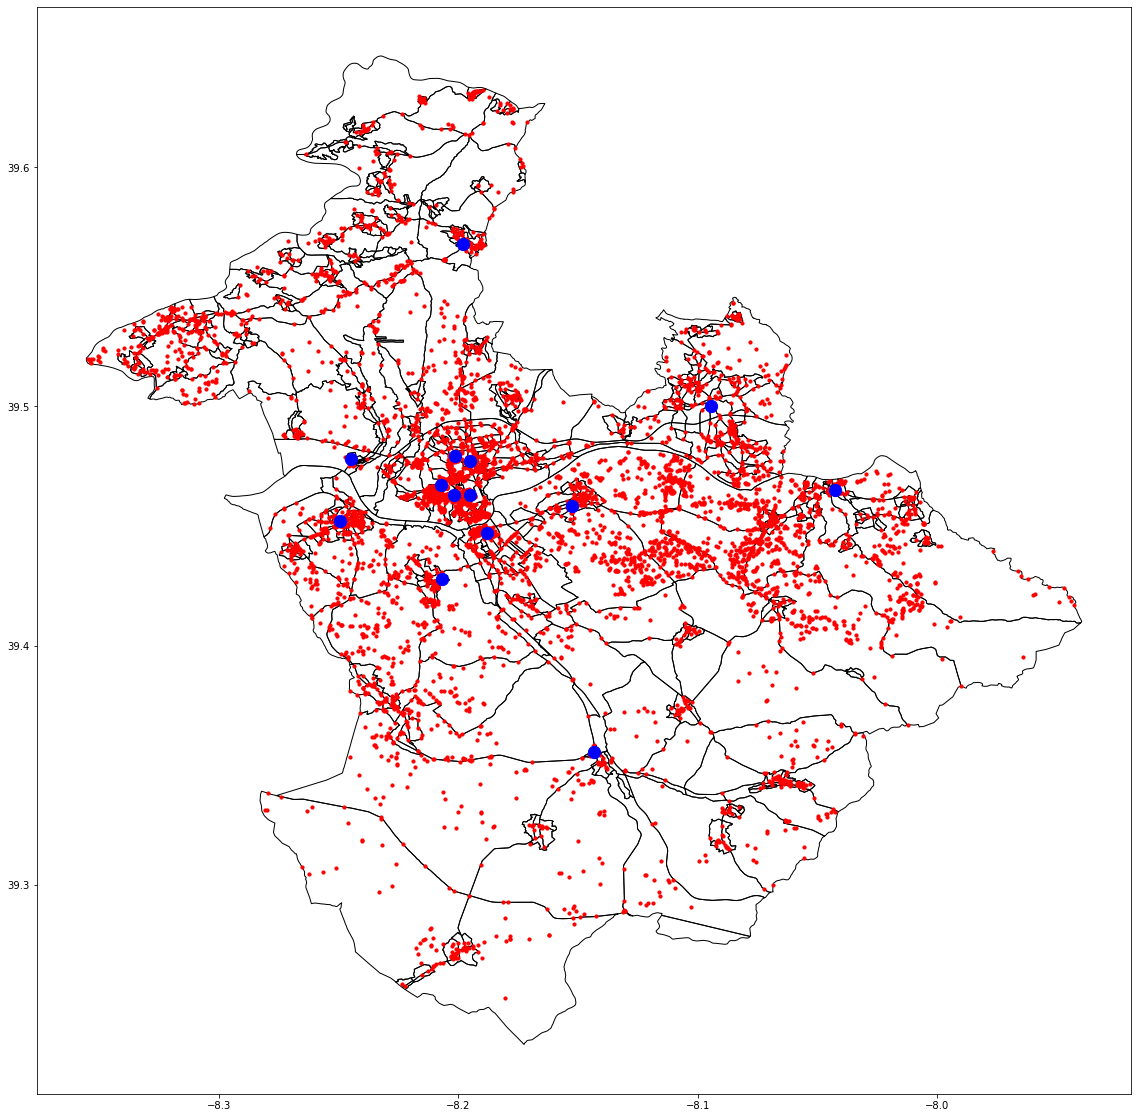

In [67]:
fig, ax = plt.subplots(figsize=(20, 20))

polygons[polygons['DTMN11']=='1401'].plot(ax=ax,facecolor='None', edgecolor='black')
nodes.plot(ax=ax,zorder=1000, color='red', markersize=10)
schoolsNetwork.plot(ax=ax, zorder=2000,color='blue', markersize=150)


,DSR,DISTRITO,CONCELHO,NUTIII,CÓD. AGRUP,AGRUPAMENT,CÓD. DGEEC,CÓD. DGPGF,ESCOLA,MORADA,...,CODDISTRIT,CODNUTIII,CODGEPESED,CODDRE,ENSINOS_LI,LONG,Unnamed_ 3,geometry,schoolX,schoolY
2088,Lisboa e Vale do Tejo,Santarém,ABRANTES,Médio Tejo,170320.0,Escolas Nº 1 de Abrantes,1401264,212325,"Escola Básica do Carvalhal, Abrantes",Rua da Escola,...,14.0,10304.0,1401588.0,103.0,AB,-8.198003,Público,POINT (-8.19800 39.56812),-8.198003,39.568115
2122,Lisboa e Vale do Tejo,Santarém,ABRANTES,Médio Tejo,170320.0,Escolas Nº 1 de Abrantes,1401062,235131,"Escola Básica de Mouriscas, Abrantes",Casal da Igreja,...,14.0,10304.0,1401588.0,103.0,B,-8.094513,Público,POINT (-8.09451 39.50037),-8.094513,39.500366
2131,Lisboa e Vale do Tejo,Santarém,ABRANTES,Médio Tejo,121502.0,Escolas Nº 2 de Abrantes,1401716,252190,"Escola Básica de Chainça, Abrantes",R. da Escola Nova,...,14.0,10304.0,1401539.0,103.0,AB,-8.201497,Público,POINT (-8.20150 39.47945),-8.201497,39.479454
2132,Lisboa e Vale do Tejo,Santarém,ABRANTES,Médio Tejo,121502.0,Escolas Nº 2 de Abrantes,1401581,269827,"Escola Básica de Rio de Moinhos, Abrantes",Rua Visconde de Abrançalha,...,14.0,10304.0,1401539.0,103.0,AB,-8.244759,Público,POINT (-8.24476 39.47813),-8.244759,39.478127
2133,Lisboa e Vale do Tejo,Santarém,ABRANTES,Médio Tejo,170320.0,Escolas Nº 1 de Abrantes,1401354,250338,"Escola Básica Maria Lucília Moita, Abrantes",Rua Professor Doutor Raimundo Mota,...,14.0,10304.0,1401588.0,103.0,AB,-8.195315,Público,POINT (-8.19531 39.47735),-8.195315,39.477348


In [ ]:
# Column name manipulation to plot data
# resultDf = resultDf.rename(columns={1:'accessN1'})
# resultDf.index = resultDf.key_0
# resultDf = resultDf.drop(columns='key_0')

# Plot results
# resultDf.plot(kind='scatter', x='accessN1', y ='IQ')

# resultDf = resultDf[resultDf['IQ']!=0]

# resultDf.plot(kind='scatter', x='accessN1', y ='IQ')

# stats.pearsonr(resultDf['accessN1'], resultDf['IQ'])

In [28]:
# Use Only when You have the previously calculated and saved
resultDfMerged = pd.read_csv('./data/finalResultsAccessbility60km_Old_beforeSchoolFix.csv', dtype={'key_0':str})

In [29]:
resultDfMerged = resultDfMerged.rename(columns={"3":'accessN3',"1":'accessN1', 'key_0':'BGRI'})                                            

In [69]:
iq_bgri.head()

,BGRI11,IQ
0,01010100101,6.285714
1,01010100102,6.210526
2,01010100103,6.000000
3,01010100104,2.000000
4,01010100105,5.642857


In [17]:
iq_bgri[iq_bgri['BGRI11']=='03135700207']

,BGRI11,IQ
46299,03135700207,8.283019


In [10]:
resultDfMerged = resultDfMerged.drop('Unnamed: 0', axis=1)

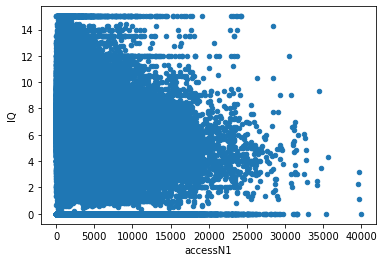

In [101]:
resultDfMerged.plot(kind='scatter', x='accessN1', y='IQ')

In [102]:
# resultDfMerged = resultDfMerged[resultDfMerged['IQ']!=0] # Isso é realmente necessário?

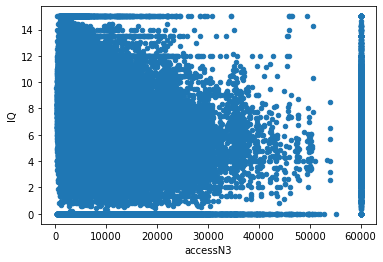

In [103]:
resultDfMerged.plot(kind='scatter', x='accessN3', y='IQ')

In [104]:
stats.pearsonr(resultDfMerged['accessN1'], resultDfMerged['IQ'])

(-0.3114594310479756, 0.0)

In [105]:
bgriIqPolygons = None
bgriIqPolygons = pd.merge(polygons, resultDfMerged[['accessN1', 'accessN3', 'IQ']], left_on=polygons.BGRI11, right_on=resultDfMerged.BGRI, how='left')
# accessibilityBGRIGeometry = accessibilityBGRIGeometry.drop(columns='key_0')

In [106]:
# bgriIqPolygons[bgriIqPolygons['LUG11DESIG']=='Aveiro'].plot(column='IQ', legend=True, scheme='EqualInterval', figsize=(15,15))

In [107]:
bgriIqPolygons = bgriIqPolygons.dropna()

In [108]:
# bgriIqPolygons[bgriIqPolygons['LUG11DESIG']=='Ílhavo'].plot(column='IQ', legend=True, scheme='EqualInterval', figsize=(15,15))

In [109]:
# bgriIqPolygons.plot(column='IQ', legend=True, scheme='EqualInterval', figsize=(15,15))

In [110]:
bgriMeans_Concelho = bgriIqPolygons[['accessN1', 'accessN3','IQ','DTMN11']].groupby('DTMN11').mean()

(-0.7961820672810029, 3.589065861790119e-62)

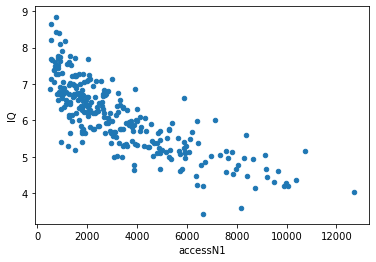

In [111]:
bgriMeans_Concelho.plot(kind='scatter', x='accessN1', y='IQ')
stats.pearsonr(bgriMeans_Concelho['accessN1'], bgriMeans_Concelho['IQ'])

(-0.5995422664765768, 1.6023718541861975e-28)

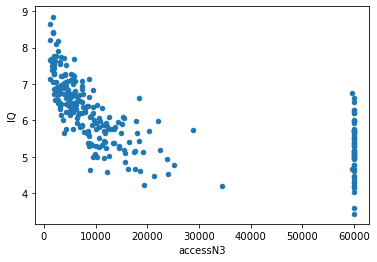

In [112]:
bgriMeans_Concelho.plot(kind='scatter', x='accessN3', y='IQ')
stats.pearsonr(bgriMeans_Concelho['accessN3'], bgriMeans_Concelho['IQ'])

In [113]:
bgriIqPolygons['Freguesia'] = bgriIqPolygons['DTMN11'] + '' + bgriIqPolygons['FR11']

In [114]:
bgriIqPolygons[bgriIqPolygons['Freguesia']=='010101']

,key_0,OBJECTID,DTMN11,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG,area,geometry,accessN1,accessN3,IQ,Freguesia
255935,01010100121,0,0101,01,001,21,01010100121,999999,Residual,14.081900,"POLYGON ((-8.27831 40.53599, -8.27847 40.53591...",13412.612305,15223.530905,6.076923,010101
255937,01010100111,0,0101,01,001,11,01010100111,014422,Foz,0.013572,"POLYGON ((-8.31943 40.54944, -8.31951 40.54947...",12083.602539,15526.708984,9.000000,010101
255938,01010100122,0,0101,01,001,22,01010100122,999999,Residual,13.783200,"POLYGON ((-8.32572 40.57917, -8.32572 40.57916...",13684.176726,17127.282951,6.611111,010101
255939,01010100103,0,0101,01,001,03,01010100103,014421,Caselho,0.109068,"POLYGON ((-8.32302 40.56370, -8.32304 40.56346...",12570.346191,13693.351562,6.000000,010101
255943,01010100119,0,0101,01,001,19,01010100119,014423,Guistola,0.007792,"POLYGON ((-8.31043 40.53467, -8.31045 40.53461...",14312.835938,17755.941406,5.222222,010101
255944,01010100118,0,0101,01,001,18,01010100118,014423,Guistola,0.069275,"POLYGON ((-8.30798 40.53372, -8.30803 40.53376...",14349.722656,17792.828125,6.705882,010101
255946,01010100120,0,0101,01,001,20,01010100120,014423,Guistola,0.014113,"POLYGON ((-8.30798 40.53372, -8.30799 40.53367...",14402.360840,17845.465820,3.652174,010101
255947,01010100123,0,0101,01,001,23,01010100123,999999,Residual,10.135600,"POLYGON ((-8.25066 40.51489, -8.25043 40.51477...",16763.156771,20206.262500,5.000000,010101
255948,01010100108,0,0101,01,001,08,01010100108,014427,Povinha,0.084990,"POLYGON ((-8.32308 40.55328, -8.32299 40.55304...",12533.400391,14741.989258,3.888889,010101
255949,01010100116,0,0101,01,001,16,01010100116,014426,Lomba,0.190983,"POLYGON ((-8.31537 40.54068, -8.31540 40.54051...",12432.445095,15875.551324,5.952381,010101


In [115]:
bgriMeans_Freguesia = bgriIqPolygons[['Freguesia', 'accessN1','accessN3', 'IQ']].groupby('Freguesia').mean()

(-0.6450488997795764, 0.0)

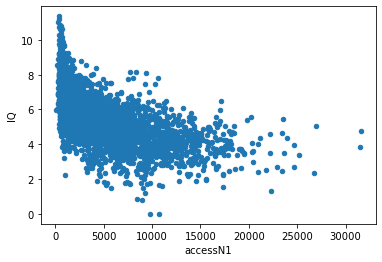

In [116]:
bgriMeans_Freguesia.plot(kind='scatter', x='accessN1', y='IQ')
stats.pearsonr(bgriMeans_Freguesia['accessN1'], bgriMeans_Freguesia['IQ'])

(-0.48176233122519213, 1.5701435217161536e-233)

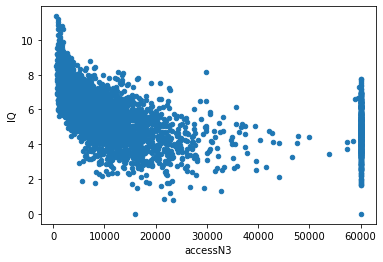

In [117]:
bgriMeans_Freguesia.plot(kind='scatter', x='accessN3', y='IQ')
stats.pearsonr(bgriMeans_Freguesia['accessN3'], bgriMeans_Freguesia['IQ'])

In [118]:
bgri_2011 = pd.read_csv('./data/BGRI_2011/BGRI2011_PT.csv',sep=';', dtype={'GEO_COD':str})

In [119]:
# Remove those bastard brackets from GEO_COD 
bgri_2011['GEO_COD'] = bgri_2011['GEO_COD'].apply(lambda x : x[1:] if x.startswith("'") else x)

In [120]:
bgri_2011['taxa_desemprego'] = (bgri_2011['N_IND_RESID_DESEMP_PROC_1EMPRG']+bgri_2011['N_IND_RESID_DESEMP_PROC_EMPRG'])/(bgri_2011['N_INDIVIDUOS_RESIDENT_20A64']+ bgri_2011['N_INDIVIDUOS_RESIDENT_15A19'])

In [121]:
bgri_2011 = bgri_2011.set_index('GEO_COD')

In [122]:
bgriMeans_Concelho = pd.merge(bgriMeans_Concelho, bgri_2011[['taxa_desemprego']], how='left', left_on=[bgriMeans_Concelho.index], right_on=[bgri_2011.index], left_index=True)
bgriMeans_Freguesia = pd.merge(bgriMeans_Freguesia, bgri_2011[['taxa_desemprego']], how='left', left_on=[bgriMeans_Freguesia.index], right_on=[bgri_2011.index], left_index=True)

In [123]:
bgriMeans_Concelho = bgriMeans_Concelho.drop(columns='key_0')
bgriMeans_Freguesia = bgriMeans_Freguesia.drop(columns='key_0')

(-0.45019149265643305, 2.803048745891709e-15)


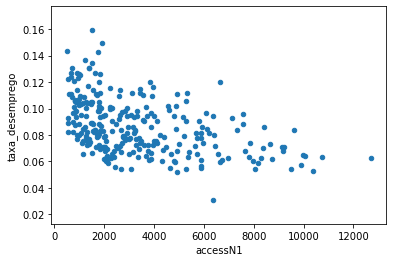

In [124]:
bgriMeans_Concelho.plot(kind='scatter', x='accessN1', y='taxa_desemprego')
print(stats.pearsonr(bgriMeans_Concelho['accessN1'], bgriMeans_Concelho['taxa_desemprego']))

(-0.2575866891936401, 1.3670441266077747e-05)


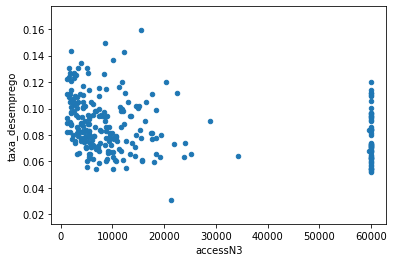

In [125]:
bgriMeans_Concelho.plot(kind='scatter', x='accessN3', y='taxa_desemprego')
print(stats.pearsonr(bgriMeans_Concelho['accessN3'], bgriMeans_Concelho['taxa_desemprego']))

(-0.2699621680868005, 2.5880338311723618e-68)


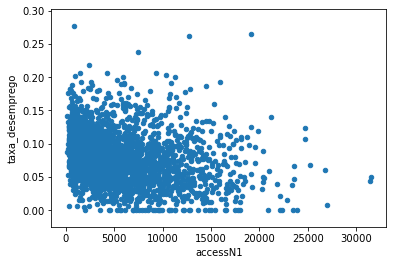

In [126]:
bgriMeans_Freguesia.plot(kind='scatter', x='accessN1', y='taxa_desemprego')
print(stats.pearsonr(bgriMeans_Freguesia['accessN1'], bgriMeans_Freguesia['taxa_desemprego']))

(-0.20709461598499884, 2.519857868163731e-40)


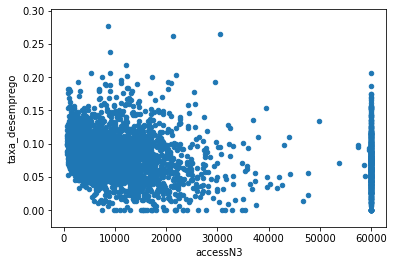

In [127]:
bgriMeans_Freguesia.plot(kind='scatter', x='accessN3', y='taxa_desemprego')
print(stats.pearsonr(bgriMeans_Freguesia['accessN3'], bgriMeans_Freguesia['taxa_desemprego']))

(-0.6450488997795764, 0.0)


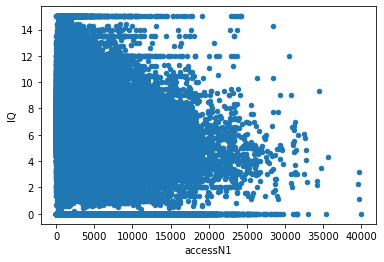

In [128]:
# Pearson para todas as subseções
bgriIqPolygons[['accessN1','IQ']].plot(kind='scatter', x='accessN1', y='IQ')
print(stats.pearsonr(bgriMeans_Freguesia['accessN1'], bgriMeans_Freguesia['IQ']))

In [129]:
# bgriMeans_Freguesia[bgriMeans_Freguesia['taxa_desemprego']==0]

In [130]:
# Características para serem usados na clusterização
# Média, Min, Max, Variancia, Número de Equipamentos per Capta

In [131]:
import numpy as np

In [132]:
data = bgriIqPolygons[['accessN1', 'IQ']].head(100).values

In [133]:
from sklearn.cluster import AgglomerativeClustering


In [134]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np

In [135]:
# Council code for Nisa
schoolsNetworkTotal.at[2117,'CODCONCELH'] = '1212'

In [136]:
# Cleaning School Council Data
temp = pd.DataFrame(schoolsNetworkTotal[['CODCONCELH']])
temp['CODCONCELH'] = temp['CODCONCELH'].astype(int).astype(str)
temp['CODCONCELH'] = temp['CODCONCELH'].apply(lambda x: str(x).zfill(4))
schoolsNetworkTotal['CODCONCELH'] = temp['CODCONCELH']

In [137]:
# Get the number of schools for each 'Concelho' and 'Freguesia'
schoolcountByCouncil = schoolsNetworkTotal[['ESCOLA','CODCONCELH']].groupby('CODCONCELH').count()

In [138]:
# Dataframe with total of Residents
residentsTotal = pd.DataFrame(bgri_2011['N_INDIVIDUOS_RESIDENT_20A64']+ bgri_2011['N_INDIVIDUOS_RESIDENT_15A19'])

In [139]:
# Média, Min, Max, Variancia, Número de Equipamentos per Capta
# Begin Cluster Analisys
bgriIqPolygons.head()

,key_0,OBJECTID,DTMN11,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG,area,geometry,accessN1,accessN3,IQ,Freguesia
0,04070200104,548,0407,02,001,04,04070200104,013810,Abreiro,0.114464,"POLYGON ((-7.29205 41.35148, -7.29106 41.35088...",8739.701172,24686.813477,3.571429,040702
1,04070200106,549,0407,02,001,06,04070200106,013810,Abreiro,0.054224,"POLYGON ((-7.29253 41.35106, -7.29230 41.35094...",8679.150879,24626.261963,4.494505,040702
2,04070200101,550,0407,02,001,01,04070200101,013811,Milhais,0.066225,"POLYGON ((-7.32701 41.35969, -7.32719 41.35966...",9957.660645,25904.771484,4.290323,040702
3,04070200102,551,0407,02,001,02,04070200102,013811,Milhais,0.130057,"POLYGON ((-7.32187 41.36047, -7.32167 41.36028...",9937.798096,25884.908691,4.760000,040702
5,04070300117,553,0407,03,001,17,04070300117,999999,Residual,1.934840,"POLYGON ((-7.17331 41.72200, -7.17320 41.72195...",11430.942437,27651.908203,0.000000,040703


In [140]:
# Metrics for Accessibility
accessStdForBGRI = bgriIqPolygons[['accessN1', 'DTMN11']].groupby('DTMN11').std()
accessMinForBGRI = bgriIqPolygons[['accessN1', 'DTMN11']].groupby('DTMN11').min()
accessMaxForBGRI = bgriIqPolygons[['accessN1', 'DTMN11']].groupby('DTMN11').max()

In [141]:
# Number of Equipaments per Capta
schoolcountByCouncil = pd.merge(schoolcountByCouncil, residentsTotal, how='left', left_on=[schoolcountByCouncil.index], right_on=[residentsTotal.index])
schoolcountByCouncil = schoolcountByCouncil.rename(columns={'key_0':'DTMN11', 0:'total_residents'})
schoolcountByCouncil['equip_per_capta'] = schoolcountByCouncil['ESCOLA']/schoolcountByCouncil['total_residents']

In [142]:
# Merging main dataframe with Aux DF for 'Equip_per_capta'
bgriMeans_Concelho = pd.merge(bgriMeans_Concelho, schoolcountByCouncil[['total_residents', 'equip_per_capta']], how='left', left_on=[bgriMeans_Concelho.index], right_on=[schoolcountByCouncil.DTMN11])

In [143]:
# DataFrame FIX after Merge
bgriMeans_Concelho = bgriMeans_Concelho.rename(columns={'key_0':'DTMN11'})
bgriMeans_Concelho.index = bgriMeans_Concelho['DTMN11']
bgriMeans_Concelho = bgriMeans_Concelho.drop('DTMN11', axis=1)

# Add data to the DataFrame
bgriMeans_Concelho['accessN1_Min'] = accessMinForBGRI['accessN1']
bgriMeans_Concelho['accessN1_Max'] = accessMaxForBGRI['accessN1']
bgriMeans_Concelho['accessN1_Std'] = accessStdForBGRI['accessN1']

In [144]:
bgriMeans_Concelho.head()

,accessN1,accessN3,IQ,taxa_desemprego,total_residents,equip_per_capta,accessN1_Min,accessN1_Max,accessN1_Std
DTMN11,,,,,,,,,
0101,2702.059626,5699.922902,6.709361,0.074270,31749,0.000409,0.000000,19680.807993,3074.824714
0102,1429.045205,4458.801491,6.632885,0.074799,16805,0.000774,14.121000,5830.901438,1026.129896
0103,1974.537553,4944.865028,6.646662,0.071074,18516,0.000702,0.000000,10692.040039,1497.860274
0104,2670.555535,6878.285104,6.201314,0.054330,14872,0.000807,72.225998,11653.454939,2400.574060
0105,893.133056,2398.367915,8.105657,0.080033,53753,0.000577,0.000000,3316.588745,561.163816


In [145]:
data = bgriMeans_Concelho[['equip_per_capta', 'accessN1', 'accessN1_Min', 'accessN1_Max', 'accessN1_Std']].values

In [146]:
# data

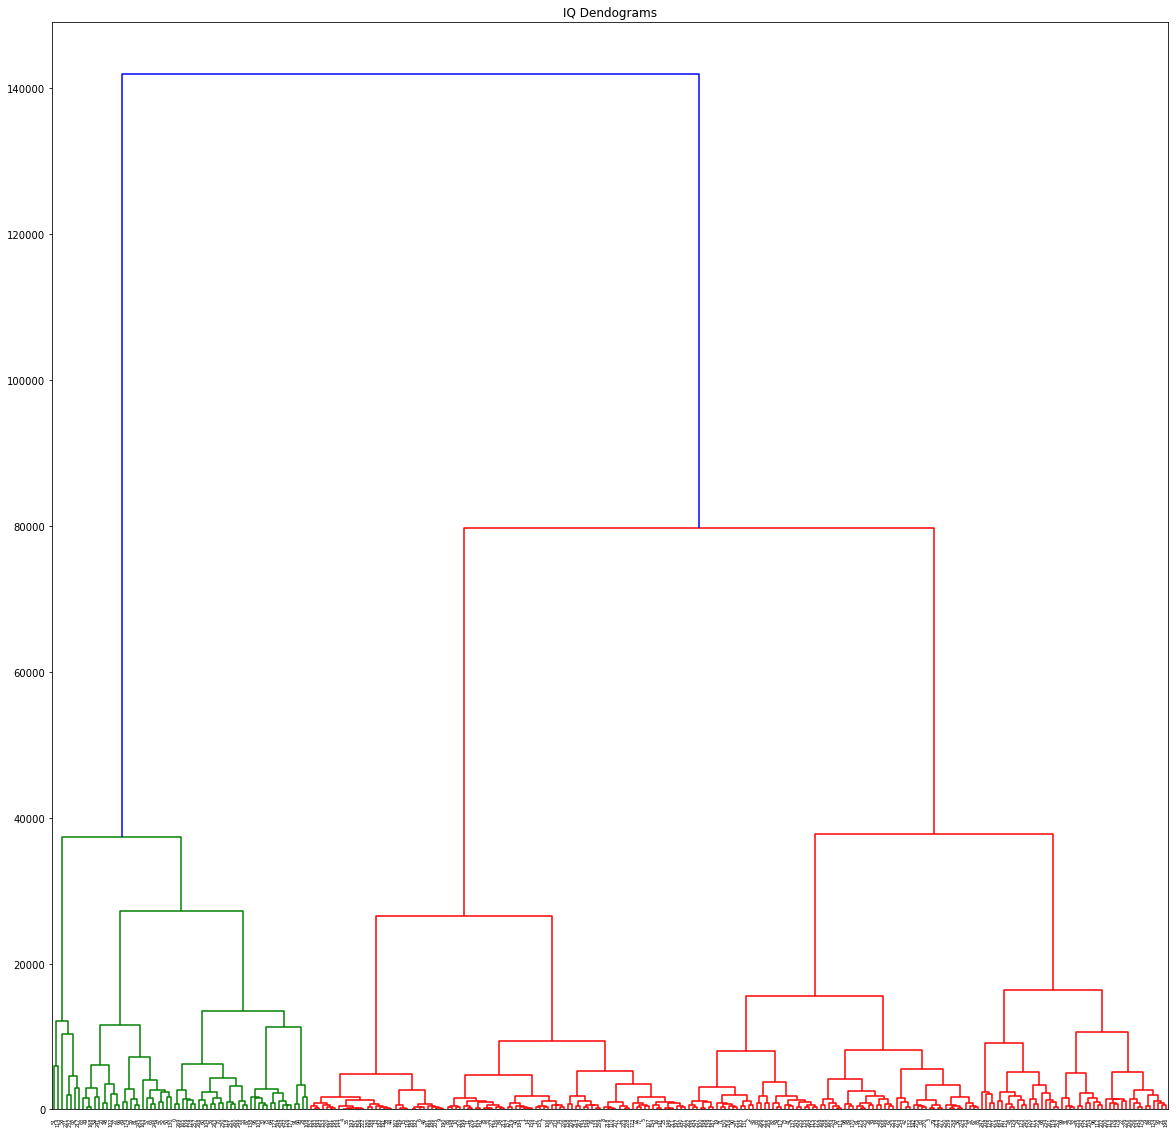

In [147]:
plt.figure(figsize=(20, 20))
plt.title("IQ Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [148]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([2, 3, 1, 1, 6, 3, 6, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 1, 1, 5, 0,
       0, 0, 0, 3, 1, 5, 2, 0, 2, 0, 0, 3, 3, 6, 2, 1, 6, 1, 3, 1, 1, 0,
       6, 1, 6, 5, 5, 5, 5, 4, 5, 2, 5, 5, 1, 5, 4, 1, 2, 1, 1, 5, 2, 5,
       5, 1, 0, 5, 2, 1, 3, 1, 3, 2, 3, 3, 3, 1, 1, 5, 1, 1, 3, 1, 3, 2,
       0, 1, 1, 2, 4, 0, 2, 2, 0, 1, 1, 0, 1, 3, 5, 2, 2, 1, 3, 3, 2, 2,
       3, 1, 0, 0, 4, 1, 6, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 5, 1,
       1, 3, 3, 1, 3, 1, 2, 1, 3, 3, 1, 0, 6, 1, 3, 3, 3, 3, 1, 6, 6, 6,
       3, 3, 6, 3, 3, 3, 1, 6, 6, 5, 0, 2, 1, 0, 5, 1, 1, 0, 1, 3, 5, 1,
       0, 2, 0, 0, 6, 6, 6, 6, 3, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 0, 3,
       1, 3, 0, 3, 0, 3, 0, 6, 0, 3, 0, 3, 3, 3, 1, 1, 3, 3, 1, 4, 3, 3,
       6, 4, 6, 3, 1, 1, 3, 3, 3, 0, 2, 1, 4, 1, 0, 0, 1, 1, 1, 1, 0, 5,
       0, 1, 2, 5, 5, 0, 2, 2, 1, 2, 0, 1, 1, 1, 0, 2, 1, 3, 2, 0, 1, 2,
       1, 1, 1, 3, 2, 2, 1, 0, 0, 1, 1, 1, 3, 1])

In [149]:
bgriMeans_Concelho['class'] = cluster.labels_

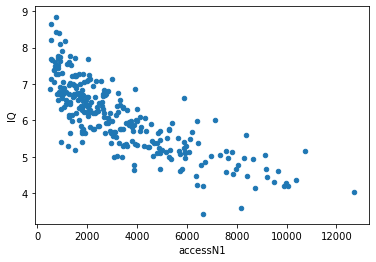

In [150]:
bgriMeans_Concelho.plot(kind='scatter', x='accessN1', y='IQ', )

In [151]:
import seaborn as sns

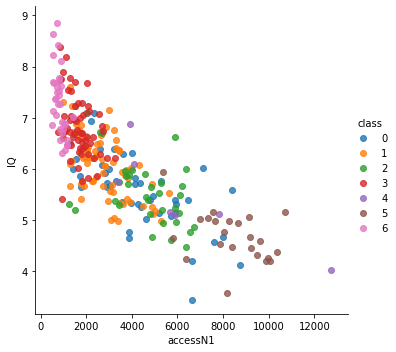

In [152]:

sns.lmplot('accessN1', 'IQ', data=bgriMeans_Concelho, hue='class', fit_reg=False)

plt.show()

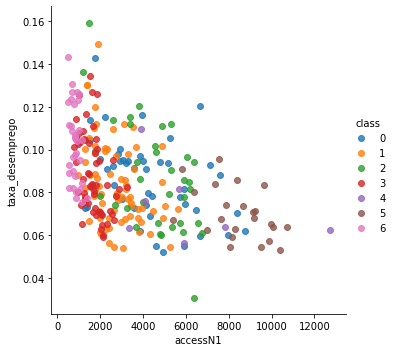

In [153]:
sns.lmplot('accessN1', 'taxa_desemprego', data=bgriMeans_Concelho, hue='class', fit_reg=False)

In [156]:
# Metrics for Accessibility
accessStdForBGRI = bgriIqPolygons[['accessN1', 'Freguesia']].groupby('Freguesia').std()
accessMinForBGRI = bgriIqPolygons[['accessN1', 'Freguesia']].groupby('Freguesia').min()
accessMaxForBGRI = bgriIqPolygons[['accessN1', 'Freguesia']].groupby('Freguesia').max()

In [157]:
# Add data to the DataFrame
bgriMeans_Freguesia['accessN1_Min'] = accessMinForBGRI['accessN1']
bgriMeans_Freguesia['accessN1_Max'] = accessMaxForBGRI['accessN1']
bgriMeans_Freguesia['accessN1_Std'] = accessStdForBGRI['accessN1']

In [158]:
# bgriMeans_Freguesia

In [159]:
# bgriIqPolygons['Freguesia'] = bgriIqPolygons['DTMN11'] + bgriIqPolygons['FR11']

In [160]:
# bgriIqPolygons[bgriIqPolygons['Freguesia']=='010101'].plot()

In [161]:
bgriIqPolygons = bgriIqPolygons.rename(columns={'key_0':'BGRI'})

In [162]:
schoolsNetworkTotal_teste = gpd.sjoin(schoolsNetworkTotal, bgriIqPolygons[['BGRI','Freguesia', 'geometry','DTMN11']], how='left', op='intersects')

In [163]:
schoolsNetworkTotal_teste[schoolsNetworkTotal_teste['Freguesia'].isnull()]

,DSR,DISTRITO,CONCELHO,NUTIII,CÓD. AGRUP,AGRUPAMENT,CÓD. DGEEC,CÓD. DGPGF,ESCOLA,MORADA,...,CODGEPESED,CODDRE,ENSINOS_LI,LONG,Unnamed_ 3,geometry,index_right,BGRI,Freguesia,DTMN11
11,Norte,Viana do Castelo,VALENÇA,Minho Lima,150587.0,"Escolas de Muralhas do Minho, Valença",1608681,271858,"Escola Básica São Pedro da Torre, Valença",R. do Monte,...,1608480.0,101.0,AB,-8.666207,Público,POINT (-8.66621 41.98805),NaN,NaN,NaN,NaN
54,Norte,Viana do Castelo,PONTE DA BARCA,Minho Lima,152626.0,Escolas de Ponte da Barca,1606001,295050,"Escola Básica de Crasto, Ponte da Barca",Azenha - s. Martinho de Crasto,...,1606743.0,101.0,AB,-8.432672,Público,POINT (-8.43267 41.77264),NaN,NaN,NaN,NaN
68,Norte,Bragança,VINHAIS,Alto Trás-os-Montes,150680.0,"Escolas D. Afonso III, Vinhais",412357,268537,"Escola Básica de Rebordelo, Vinhais",Rebordelo,...,412497.0,101.0,AB,-7.166163,Público,POINT (-7.16616 41.74021),NaN,NaN,NaN,NaN
70,Norte,Bragança,BRAGANÇA,Alto Trás-os-Montes,151816.0,"Escolas Emídio Garcia, Bragança",402716,268604,"Escola Básica de Rebordãos, Bragança",Rebordãos,...,402268.0,101.0,AB,-6.820771,Público,POINT (-6.82077 41.73983),NaN,NaN,NaN,NaN
81,Norte,Braga,TERRAS DE BOURO,Cavado,150319.0,Escolas de Terras de Bouro,310736,345994,Escola Básica e Secundária de Terras de Bouro,Avenida Doutor Artur Adriano Arantes,...,310736.0,101.0,BCDE,-8.306689,Público,POINT (-8.30669 41.71800),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,Algarve,Faro,FARO,Algarve,145567.0,"Escolas Pinheiro e Rosa, Faro",805105,208449,"Escola Básica de Bordeira, Faro",R. da Escola,...,805036.0,105.0,AB,-7.921994,Público,POINT (-7.92199 37.12637),NaN,NaN,NaN,NaN
3360,Algarve,Faro,LOULÉ,Algarve,145178.0,"Escolas Eng. Duarte Pacheco, Loulé",808066,207615,"Escola Básica de Benfarras, Loulé",Benfarras,...,808032.0,105.0,AB,-8.130274,Público,POINT (-8.13027 37.11992),NaN,NaN,NaN,NaN
3397,Algarve,Faro,FARO,Algarve,145567.0,"Escolas Pinheiro e Rosa, Faro",805016,293179,"Escola Básica de Conceição, Faro",Lg da Igreja,...,805036.0,105.0,AB,-7.918252,Público,POINT (-7.91825 37.06181),NaN,NaN,NaN,NaN
3407,Algarve,Faro,OLHÃO,Algarve,145191.0,"Escolas Professor Paula Nogueira, Olhão",810148,260058,Escola Básica n.º 5 de Olhão,R. João de Jesus Ventura,...,810464.0,105.0,B,-7.848349,Público,POINT (-7.84835 37.03748),NaN,NaN,NaN,NaN


In [164]:
schoolsNetworkTotal_teste=gpd.sjoin(schoolsNetworkTotal, bgriIqPolygons[['BGRI11','Freguesia', 'geometry','DTMN11']], how='left', op='within')

In [165]:
# Spatial Join to find the school network --> Rodar aqui
schoolsNetworkTotal_Freguesia = gpd.sjoin(schoolsNetworkTotal, bgriIqPolygons[['BGRI11','Freguesia', 'geometry','DTMN11']], how='left', op='intersects')

In [166]:
schoolsNetworkTotal.head()

,DSR,DISTRITO,CONCELHO,NUTIII,CÓD. AGRUP,AGRUPAMENT,CÓD. DGEEC,CÓD. DGPGF,ESCOLA,MORADA,...,CODFUNCION,CODCONCELH,CODDISTRIT,CODNUTIII,CODGEPESED,CODDRE,ENSINOS_LI,LONG,Unnamed_ 3,geometry
0,Norte,Viana do Castelo,MELGAÇO,Minho Lima,152602.0,Escolas de Melgaço,1603773,294329,Escola Básica de Melgaço,Avenida Capitão Salgueiro Maia,...,1.0,1603,16.0,10101.0,1603190.0,101.0,AB,-8.260877,Público,POINT (-8.26088 42.10693)
1,Norte,Viana do Castelo,MONÇÃO,Minho Lima,153023.0,Escolas de Monção,1604149,291663,"Escola Básica José Pinheiro Gonçalves, Monção",Bairro das Escolas Primárias,...,1.0,1604,16.0,10101.0,1604079.0,101.0,AB,-8.476451,Público,POINT (-8.47645 42.07520)
2,Norte,Viana do Castelo,MELGAÇO,Minho Lima,152602.0,Escolas de Melgaço,1603780,265342,"Escola Básica de Pomares, Melgaço",Pomares,...,1.0,1603,16.0,10101.0,1603190.0,101.0,AB,-8.277731,Público,POINT (-8.27773 42.05977)
3,Norte,Viana do Castelo,MONÇÃO,Minho Lima,153023.0,Escolas de Monção,1604542,291614,"Escola Básica de Estrada, Monção",Estrada,...,1.0,1604,16.0,10101.0,1604079.0,101.0,AB,-8.488950,Público,POINT (-8.48895 42.05353)
4,Norte,Viana do Castelo,VALENÇA,Minho Lima,150587.0,"Escolas de Muralhas do Minho, Valença",1608974,294330,"Escola Básica de Friestas, Valença",Rua Amaro da Costa - Trofa de Cima,...,1.0,1608,16.0,10101.0,1608480.0,101.0,AB,-8.571300,Público,POINT (-8.57130 42.04446)


In [167]:
schoolsNetworkTotal_Freguesia[schoolsNetworkTotal_Freguesia['Freguesia'].isna()]

,DSR,DISTRITO,CONCELHO,NUTIII,CÓD. AGRUP,AGRUPAMENT,CÓD. DGEEC,CÓD. DGPGF,ESCOLA,MORADA,...,CODGEPESED,CODDRE,ENSINOS_LI,LONG,Unnamed_ 3,geometry,index_right,BGRI11,Freguesia,DTMN11
11,Norte,Viana do Castelo,VALENÇA,Minho Lima,150587.0,"Escolas de Muralhas do Minho, Valença",1608681,271858,"Escola Básica São Pedro da Torre, Valença",R. do Monte,...,1608480.0,101.0,AB,-8.666207,Público,POINT (-8.66621 41.98805),NaN,NaN,NaN,NaN
54,Norte,Viana do Castelo,PONTE DA BARCA,Minho Lima,152626.0,Escolas de Ponte da Barca,1606001,295050,"Escola Básica de Crasto, Ponte da Barca",Azenha - s. Martinho de Crasto,...,1606743.0,101.0,AB,-8.432672,Público,POINT (-8.43267 41.77264),NaN,NaN,NaN,NaN
68,Norte,Bragança,VINHAIS,Alto Trás-os-Montes,150680.0,"Escolas D. Afonso III, Vinhais",412357,268537,"Escola Básica de Rebordelo, Vinhais",Rebordelo,...,412497.0,101.0,AB,-7.166163,Público,POINT (-7.16616 41.74021),NaN,NaN,NaN,NaN
70,Norte,Bragança,BRAGANÇA,Alto Trás-os-Montes,151816.0,"Escolas Emídio Garcia, Bragança",402716,268604,"Escola Básica de Rebordãos, Bragança",Rebordãos,...,402268.0,101.0,AB,-6.820771,Público,POINT (-6.82077 41.73983),NaN,NaN,NaN,NaN
81,Norte,Braga,TERRAS DE BOURO,Cavado,150319.0,Escolas de Terras de Bouro,310736,345994,Escola Básica e Secundária de Terras de Bouro,Avenida Doutor Artur Adriano Arantes,...,310736.0,101.0,BCDE,-8.306689,Público,POINT (-8.30669 41.71800),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,Algarve,Faro,FARO,Algarve,145567.0,"Escolas Pinheiro e Rosa, Faro",805105,208449,"Escola Básica de Bordeira, Faro",R. da Escola,...,805036.0,105.0,AB,-7.921994,Público,POINT (-7.92199 37.12637),NaN,NaN,NaN,NaN
3360,Algarve,Faro,LOULÉ,Algarve,145178.0,"Escolas Eng. Duarte Pacheco, Loulé",808066,207615,"Escola Básica de Benfarras, Loulé",Benfarras,...,808032.0,105.0,AB,-8.130274,Público,POINT (-8.13027 37.11992),NaN,NaN,NaN,NaN
3397,Algarve,Faro,FARO,Algarve,145567.0,"Escolas Pinheiro e Rosa, Faro",805016,293179,"Escola Básica de Conceição, Faro",Lg da Igreja,...,805036.0,105.0,AB,-7.918252,Público,POINT (-7.91825 37.06181),NaN,NaN,NaN,NaN
3407,Algarve,Faro,OLHÃO,Algarve,145191.0,"Escolas Professor Paula Nogueira, Olhão",810148,260058,Escola Básica n.º 5 de Olhão,R. João de Jesus Ventura,...,810464.0,105.0,B,-7.848349,Público,POINT (-7.84835 37.03748),NaN,NaN,NaN,NaN


In [168]:
# Clustering of Freguesias
# Get the number of schools for each 'Concelho' and 'Freguesia'
schoolcountByFreguesia = schoolsNetworkTotal_Freguesia[['ESCOLA','Freguesia']].groupby('Freguesia').count()

In [169]:
# Number of Equipaments per Capta
bgriMeans_Freguesia = pd.merge(bgriMeans_Freguesia, residentsTotal, how='left', left_on=[bgriMeans_Freguesia.index], right_on=[residentsTotal.index])
schoolcountByFreguesia = pd.merge(schoolcountByFreguesia, residentsTotal, how='right', left_on=[schoolcountByFreguesia.index], right_on=[residentsTotal.index])
schoolcountByFreguesia = schoolcountByFreguesia.rename(columns={'key_0':'Freguesia', 0:'total_residents'})
schoolcountByFreguesia['equip_per_capta'] = schoolcountByFreguesia['ESCOLA']/schoolcountByFreguesia['total_residents']

In [170]:
# Adjust BGRI MEans Freguesia to merge with SChool Count
bgriMeans_Freguesia = bgriMeans_Freguesia.rename(columns={'key_0':'Freguesia'})
bgriMeans_Freguesia.index = bgriMeans_Freguesia.Freguesia
bgriMeans_Freguesia = bgriMeans_Freguesia.drop(columns='Freguesia')

In [171]:
bgriMeans_Freguesia.head()

,accessN1,accessN3,IQ,taxa_desemprego,accessN1_Min,accessN1_Max,accessN1_Std,0
Freguesia,,,,,,,,
010101,13152.095799,16190.849977,5.310229,0.048673,11585.515625,16763.156771,1355.671054,226
010102,751.985015,4065.956264,7.166374,0.086813,88.235502,1502.871521,400.977367,910
010103,2110.494798,5504.383487,7.005636,0.070376,262.962500,6239.367676,1037.747898,2714
010104,1698.215306,3380.604202,6.688838,0.081334,0.000000,5097.012451,1327.911220,7586
010105,1050.148671,4206.092138,6.768906,0.090686,222.589756,2228.896415,476.267516,1224


In [172]:
# Merging main dataframe with Aux DF for 'Equip_per_capta'
bgriMeans_Freguesia = pd.merge(bgriMeans_Freguesia, schoolcountByFreguesia[['total_residents', 'equip_per_capta']], how='left', left_on=[bgriMeans_Freguesia.index], right_on=[schoolcountByFreguesia.Freguesia])

In [173]:
# Clean bgriMeans_Freguesia
bgriMeans_Freguesia = bgriMeans_Freguesia.rename(columns={'key_0':'Freguesia'})
bgriMeans_Freguesia.index = bgriMeans_Freguesia.Freguesia
bgriMeans_Freguesia = bgriMeans_Freguesia.drop(columns='Freguesia')

In [174]:
bgriMeans_Freguesia = bgriMeans_Freguesia.rename(columns={0:'total_residents'})

In [175]:
schoolcountByFreguesia.head()

,Freguesia,ESCOLA,total_residents,equip_per_capta
0,010102,1.0,910,0.001099
1,010103,1.0,2714,0.000368
2,010104,3.0,7586,0.000395
3,010105,1.0,1224,0.000817
4,010112,1.0,2233,0.000448


In [176]:
# bgriMeans_Freguesia['equip_per_capta'] = bgriMeans_Freguesia['ESCOLA']/bgriMeans_Freguesia['total_residents']

In [177]:
bgriMeans_Freguesia = bgriMeans_Freguesia.fillna(0)

In [178]:
bgriMeans_Freguesia.head()

,accessN1,accessN3,IQ,taxa_desemprego,accessN1_Min,accessN1_Max,accessN1_Std,total_residents,total_residents,equip_per_capta
Freguesia,,,,,,,,,,
010101,13152.095799,16190.849977,5.310229,0.048673,11585.515625,16763.156771,1355.671054,226,226,0.000000
010102,751.985015,4065.956264,7.166374,0.086813,88.235502,1502.871521,400.977367,910,910,0.001099
010103,2110.494798,5504.383487,7.005636,0.070376,262.962500,6239.367676,1037.747898,2714,2714,0.000368
010104,1698.215306,3380.604202,6.688838,0.081334,0.000000,5097.012451,1327.911220,7586,7586,0.000395
010105,1050.148671,4206.092138,6.768906,0.090686,222.589756,2228.896415,476.267516,1224,1224,0.000817


In [179]:
data_freguesia = bgriMeans_Freguesia[['equip_per_capta', 'accessN1', 'accessN1_Min', 'accessN1_Max', 'accessN1_Std']].values

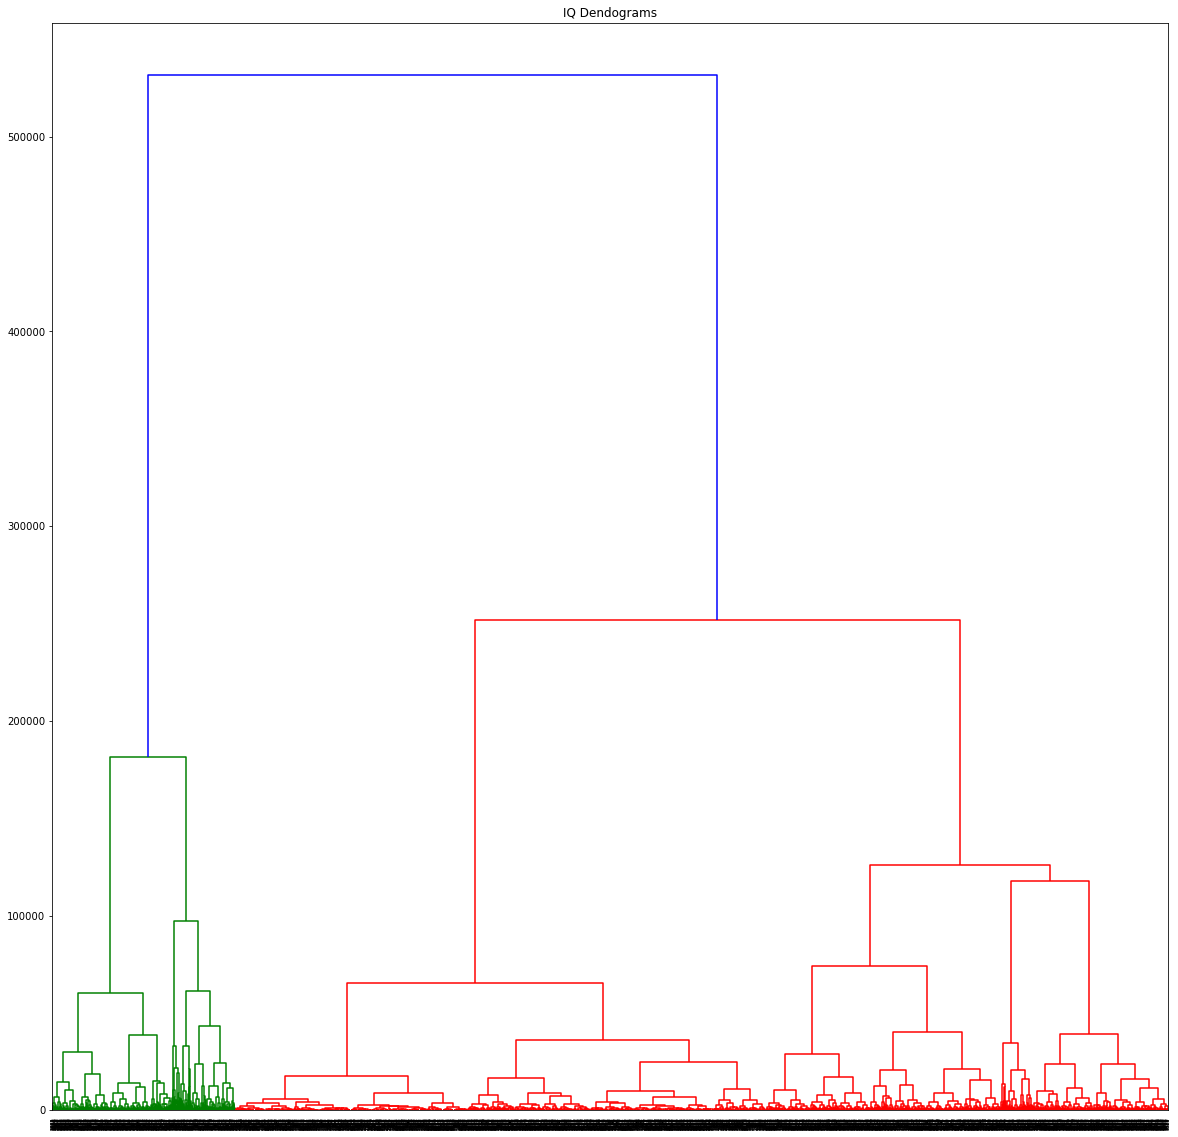

In [180]:
plt.figure(figsize=(20, 20))
plt.title("IQ Dendograms")
dend = shc.dendrogram(shc.linkage(data_freguesia, method='ward'))

In [181]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_freguesia)

array([0, 2, 1, ..., 2, 1, 2])

In [182]:
bgriMeans_Freguesia['class'] = cluster.labels_

In [183]:
bgriMeans_Freguesia.head()

,accessN1,accessN3,IQ,taxa_desemprego,accessN1_Min,accessN1_Max,accessN1_Std,total_residents,total_residents,equip_per_capta,class
Freguesia,,,,,,,,,,,
010101,13152.095799,16190.849977,5.310229,0.048673,11585.515625,16763.156771,1355.671054,226,226,0.000000,0
010102,751.985015,4065.956264,7.166374,0.086813,88.235502,1502.871521,400.977367,910,910,0.001099,2
010103,2110.494798,5504.383487,7.005636,0.070376,262.962500,6239.367676,1037.747898,2714,2714,0.000368,1
010104,1698.215306,3380.604202,6.688838,0.081334,0.000000,5097.012451,1327.911220,7586,7586,0.000395,2
010105,1050.148671,4206.092138,6.768906,0.090686,222.589756,2228.896415,476.267516,1224,1224,0.000817,2


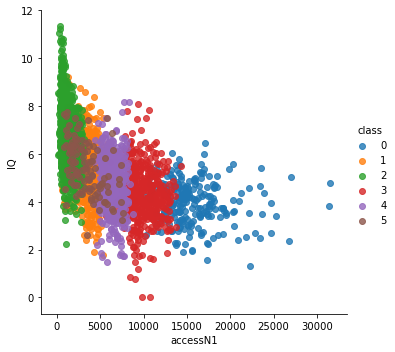

In [184]:
sns.lmplot('accessN1', 'IQ', data=bgriMeans_Freguesia, hue='class', fit_reg=False)

plt.show()

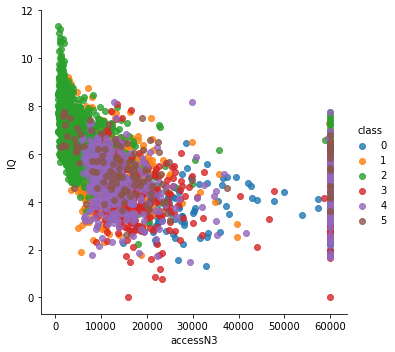

In [185]:
sns.lmplot('accessN3', 'IQ', data=bgriMeans_Freguesia, hue='class', fit_reg=False)

plt.show()

In [186]:
bgriMeans_Concelho.head()

,accessN1,accessN3,IQ,taxa_desemprego,total_residents,equip_per_capta,accessN1_Min,accessN1_Max,accessN1_Std,class
DTMN11,,,,,,,,,,
0101,2702.059626,5699.922902,6.709361,0.074270,31749,0.000409,0.000000,19680.807993,3074.824714,2
0102,1429.045205,4458.801491,6.632885,0.074799,16805,0.000774,14.121000,5830.901438,1026.129896,3
0103,1974.537553,4944.865028,6.646662,0.071074,18516,0.000702,0.000000,10692.040039,1497.860274,1
0104,2670.555535,6878.285104,6.201314,0.054330,14872,0.000807,72.225998,11653.454939,2400.574060,1
0105,893.133056,2398.367915,8.105657,0.080033,53753,0.000577,0.000000,3316.588745,561.163816,6


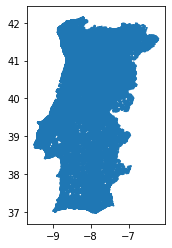

In [209]:
bgriIqPolygons.plot()

### This will be used to plot the the regions by class

In [188]:
polygons['geometry'] = polygons.buffer(0.01)


In [189]:
concelho_polygons = polygons[['DTMN11', 'geometry']].dissolve(by='DTMN11', as_index=False)

In [190]:
concelho_polygons.index = concelho_polygons.DTMN11

In [191]:
bgriMeans_Concelho = pd.merge(bgriMeans_Concelho, concelho_polygons[['geometry']], how='left', left_on=[bgriMeans_Concelho.index], right_on=[concelho_polygons.index] )

In [192]:
bgriMeans_Concelho = bgriMeans_Concelho.rename(columns={'key_0':'Concelho'})
bgriMeans_Concelho.index = bgriMeans_Concelho.Concelho
bgriMeans_Concelho = bgriMeans_Concelho.drop(columns='Concelho')

In [193]:
bgriMeans_Concelho = gpd.GeoDataFrame(bgriMeans_Concelho)

### Routine to plot Freguesias by Class


In [194]:
bgriIqPolygons['geometry'] = polygons.buffer(0.01)

In [195]:
freguesia_polygons = bgriIqPolygons[['Freguesia', 'geometry']].dropna().dissolve(by='Freguesia')

In [196]:
# freguesia_polygons = bgriIqPolygons[[]]
bgriMeans_Freguesia = pd.merge(bgriMeans_Freguesia, freguesia_polygons, how='left', left_on=[bgriMeans_Freguesia.index], right_on=[bgriIqPolygons[['Freguesia', 'geometry']].Freguesia])

KeyError: 0         040702
1         040702
2         040702
3         040702
5         040703
           ...  
255950    010101
255952    010101
255953    010101
255954    010101
255957    010101
Name: Freguesia, Length: 201084, dtype: object

In [197]:
bgriMeans_Freguesia.head()

,accessN1,accessN3,IQ,taxa_desemprego,accessN1_Min,accessN1_Max,accessN1_Std,total_residents,total_residents,equip_per_capta,class
Freguesia,,,,,,,,,,,
010101,13152.095799,16190.849977,5.310229,0.048673,11585.515625,16763.156771,1355.671054,226,226,0.000000,0
010102,751.985015,4065.956264,7.166374,0.086813,88.235502,1502.871521,400.977367,910,910,0.001099,2
010103,2110.494798,5504.383487,7.005636,0.070376,262.962500,6239.367676,1037.747898,2714,2714,0.000368,1
010104,1698.215306,3380.604202,6.688838,0.081334,0.000000,5097.012451,1327.911220,7586,7586,0.000395,2
010105,1050.148671,4206.092138,6.768906,0.090686,222.589756,2228.896415,476.267516,1224,1224,0.000817,2


In [ ]:
iq_bgri.head(1).apply(lambda x:x)

In [199]:
bgriMeans_Concelho.to_csv('./data/bkp_bgriMeansConcelho.csv')
bgriMeans_Freguesia.to_csv('./data/bkp_bgriMeansFreguesia.csv')

In [206]:
bgriMeans_Freguesia

,accessN1,accessN3,IQ,taxa_desemprego,accessN1_Min,accessN1_Max,accessN1_Std,total_residents,total_residents,equip_per_capta,class
Freguesia,,,,,,,,,,,
010101,13152.095799,16190.849977,5.310229,0.048673,11585.515625,16763.156771,1355.671054,226,226,0.000000,0
010102,751.985015,4065.956264,7.166374,0.086813,88.235502,1502.871521,400.977367,910,910,0.001099,2
010103,2110.494798,5504.383487,7.005636,0.070376,262.962500,6239.367676,1037.747898,2714,2714,0.000368,1
010104,1698.215306,3380.604202,6.688838,0.081334,0.000000,5097.012451,1327.911220,7586,7586,0.000395,2
010105,1050.148671,4206.092138,6.768906,0.090686,222.589756,2228.896415,476.267516,1224,1224,0.000817,2
...,...,...,...,...,...,...,...,...,...,...,...
182408,1264.893625,4329.989671,5.845201,0.057416,83.130501,4140.940411,919.623821,418,418,0.002392,2
182409,2099.094848,7165.858711,6.059377,0.063781,120.721331,7272.604221,1119.098208,878,878,0.001139,1
182410,1700.983832,7923.232469,5.575897,0.097002,0.000000,3622.126953,1045.770081,567,567,0.001764,2


In [207]:
resultDfMerged.head()

,BGRI,accessN1,2,accessN3,IQ
0,14010100103,8804.343018,12840.260010,13261.742676,2.444444
1,14010100104,8319.824707,12355.741699,12777.225098,3.333333
2,14010100105,8189.029785,12224.947266,12646.429688,4.000000
3,14010100106,6393.092285,11065.426107,11486.908854,6.444444
4,14010100107,6853.469971,10889.387207,11310.869629,5.857143


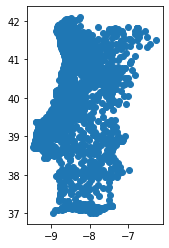